In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

### Libraries

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim import lr_scheduler
from torch import optim
import copy
from datetime import time
import wandb
import os

### Custom

In [16]:
from cv_geoguessr.grid.grid_partitioning import Partitioning
from cv_geoguessr.utils.plot_images import plot_images
from cv_geoguessr.utils.evaluation import create_confusion_matrix
from cv_geoguessr.data.data_loader import get_data_loader
from cv_geoguessr.data.data_loader import preview_images
from cv_geoguessr.network.training import train_model
from cv_geoguessr.network.model import load_model
from cv_geoguessr.network.model import lock_layers


## Colab specific

Run only when using Colab.

In [4]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


## Model constants

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

SESSION = "super-sweep-1"
BASE_FOLDER = "./checkpoints"
CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

Device: cuda:0


In [23]:
config = {
    "train_batch_size": 32,
    "test_batch_size": 100,
    "cell_width": 0.01,
    "voronoi": True,
    "lr": 0.001,
    "momentum": 0.9,
    "gamma": 0.1,
    "lr_decay_step": 7,
    "epochs": 25,
    "lock_factor": 0.8 # How much of the layers are locked 1 for every thing 0 for training the whole model
}

### Set up grid partitioning

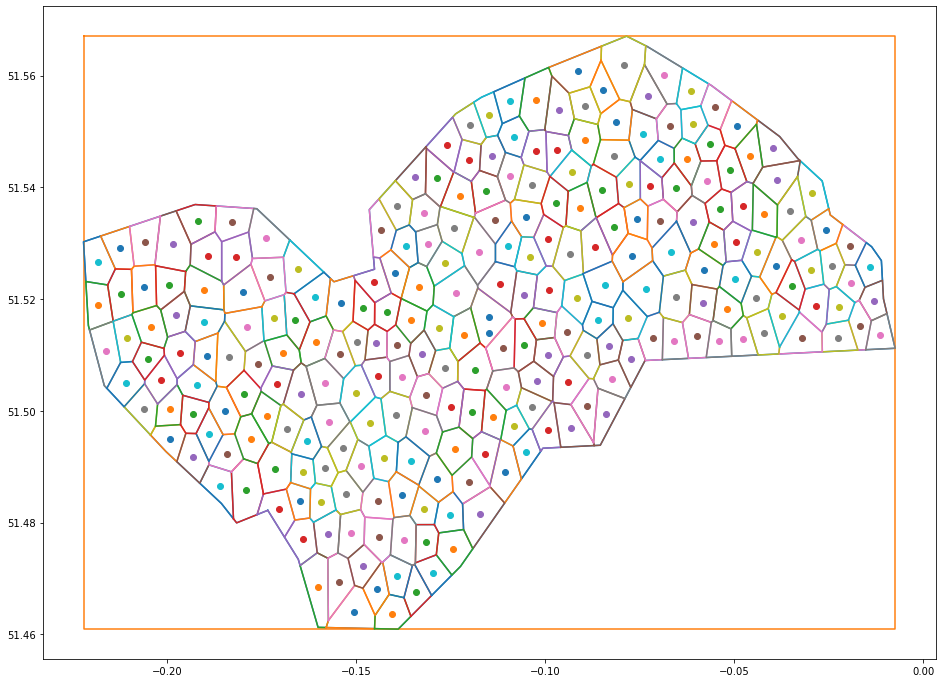

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
grid_partitioning = Partitioning(CITY_BOUNDS_FILE,
                                 cell_width=config["cell_width"],
                                 voronoi=config["voronoi"])
config["number_of_grid_elements"] = len(grid_partitioning)
grid_partitioning.plot()

### Create the data loaders

In [25]:
data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD)

## Train on the grid output


In [8]:
def setup_and_train():
    with wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", config={**config}) as run:
        wandbconfig = wandb.config

        SESSION = wandb.run.name
        BASE_FOLDER = "./checkpoints"
        CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

        # Create the model and lock the layers
        resnet50 = models.resnet50(pretrained=True, progress=True)
        resnet50.fc = nn.Linear(resnet50.fc.in_features, wandbconfig["number_of_grid_elements"])
        resnet50.to(device)
        resnet50 = lock_layers(resnet50, (3, 224, 224), wandbconfig["lock_factor"])

        # create the checkpoint folder and save the untrained model
        if not os.path.isdir(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

        # Define the criterion, optimizer and exp_lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(resnet50.parameters(), lr=wandbconfig["lr"], momentum=wandbconfig["momentum"])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=wandbconfig["lr_decay_step"], gamma=wandbconfig["gamma"])

        # Train the model
        resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, data_loaders,
                       data_set_sizes, grid_partitioning, CHECKPOINT_FOLDER, device, num_epochs=config["epochs"])

In [ ]:
config["lock_factor"] = 0.7

setup_and_train()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Problem at: C:\Users\Sjoerd Groot\AppData\Local\Temp\ipykernel_6696\2166011242.py 2 setup_and_train


Traceback (most recent call last):
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\wandb_init.py", line 999, in init
    run = wi.init()
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\wandb_init.py", line 651, in init
    backend.cleanup()
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\backend\backend.py", line 246, in cleanup
    self.interface.join()
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\interface\interface_shared.py", line 475, in join
    super().join()
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\interface\interface.py", line 666, in join
    _ = self._communicate_shutdown()
  File "E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\wandb\sdk\interface\interface_shared.py", line 472, in _communicate_shutdown
    _ = self._communicate(record)
  F

In [ ]:
sweep_config = {
  "name" : "unlock sweep 3",
  "method" : "grid",
  # "metric" : {
  #     "name" : "Accuracy/val",
  #     "goal" : "maximize"
  # },
  "parameters" : {
    "lock_factor": {
        "values": [0.9, 0.7, 0.6, 0.5]
    },
    # "lr": {
    #     "min" : 0.0005,
    #     "max" : 0.005,
    # },
    # "momentum": {
    #     "min" : 0.7,
    #     "max" : 1.0,
    # },
    # "gamma": {
    #     "min" : 0.0,
    #     "max" : 0.5,
    # },
    # "lr_decay_step": {
    #     "min" : 2,
    #     "max" : 20,
    # },
  }
}


sweep_id = wandb.sweep(sweep_config, project="CV-GeoGuessr", entity="cv-geoguessr")

# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=setup_and_train, project="CV-GeoGuessr", entity="cv-geoguessr")

Create sweep with ID: 9c1z2m2m
Sweep URL: https://wandb.ai/cv-geoguessr/CV-GeoGuessr/sweeps/9c1z2m2m


wandb: Agent Starting Run: 4tlzxwwp with config:
wandb: 	lock_factor: 0.9
wandb: Currently logged in as: sjoerdgroot (cv-geoguessr). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


285/317 params locked
Epoch 0/24
----------
train loss: 5.5076 | accuracy: 0.0069                 
val loss: 5.4404 | accuracy: 0.0155                 
0.006873879258816497	0.0155
Epoch 1/24
----------
train loss: 5.3226 | accuracy: 0.0207                 
val loss: 5.2544 | accuracy: 0.0225                 
0.020721259214983065	0.0225
Epoch 2/24
----------
train loss: 5.1158 | accuracy: 0.0363                 
val loss: 5.1038 | accuracy: 0.0320                 
0.03626220362622036	0.032
Epoch 3/24
----------


In [21]:
# only works if the loaded model has the same output as the current model
resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, config["number_of_grid_elements"])
resnet50.to(device)
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/super-sweep-1/epoch_24.ckpt"
resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, config["lock_factor"], device)

255/317 params locked
255/317 params locked


In [ ]:
# now train with the loaded model with more layers unlocked

# optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=config["epochs"])


In [26]:
confusion_matrix = create_confusion_matrix(resnet50, grid_partitioning, data_loaders['val'], False, device)
print(confusion_matrix.to('cpu'))

tensor([[ 33.0291,   2.3891,  10.3262,  ...,  14.3159, -18.2800,  -5.8745],
        [  4.8796,  16.6477,   1.5979,  ...,  -1.5567,   8.3210,   4.9231],
        [  7.9406,   8.3684,   6.2089,  ...,   7.1953,  -8.1029,  -4.4218],
        ...,
        [  8.6235,  -1.9627,  -3.3313,  ...,  19.1051,   0.0989,  -4.8380],
        [  6.7530,   4.8707,  -4.5915,  ...,   2.8048,  20.2387,   5.3156],
        [  5.7032,   8.4855,  -1.0796,  ...,  -2.1114,  14.1622,   8.9371]])


In [28]:
from cv_geoguessr.utils.plot_results import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix)

Error in callback <function flush_figures at 0x0000022A93597790> (for post_execute):


KeyboardInterrupt: 

In [30]:
confusion_matrix.to('cpu')
print(confusion_matrix.shape)


torch.Size([252, 252])


In [35]:
# confusion_matrix = confusion_matrix.to('cpu')
# print(confusion_matrix[100, :])

plot_confusion_matrix(confusion_matrix)


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000022A93597790> (for post_execute):


KeyboardInterrupt: 

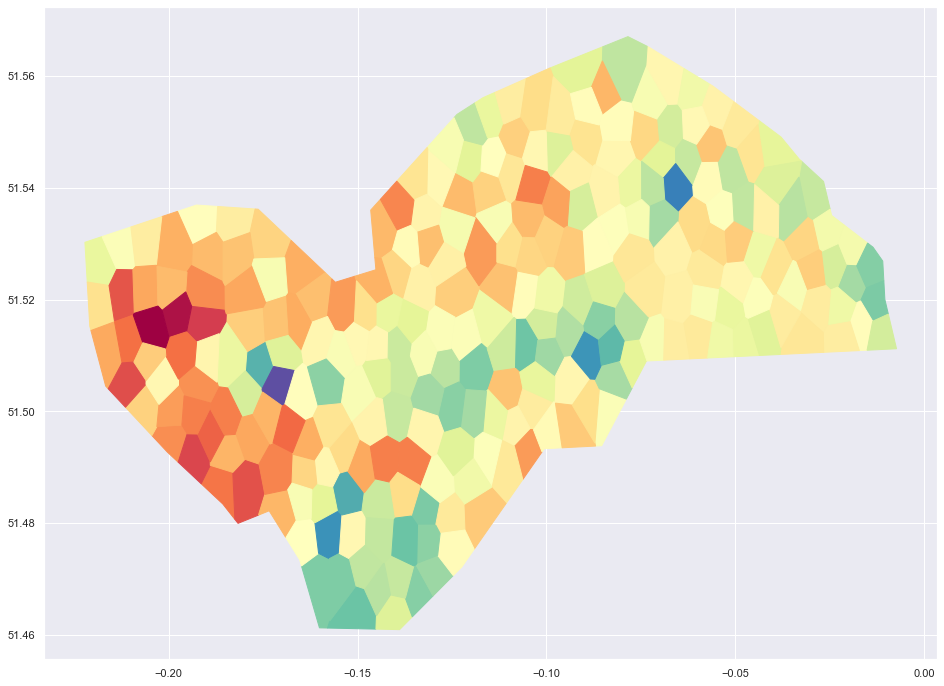

In [52]:
i = 250
p_min = torch.min(confusion_matrix[i, :])
p_max = torch.max(confusion_matrix[i, :])
pred_cell_i = 1 - (confusion_matrix[i, :] - p_min) / (p_max - p_min)
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction(pred_cell_i)

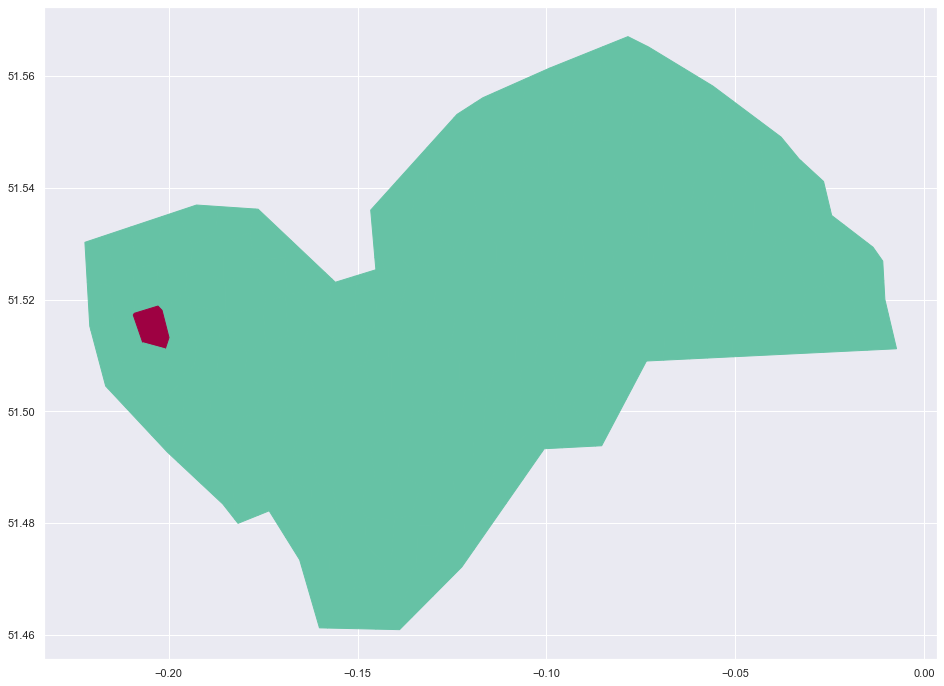

In [53]:
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction([0.8 if x != i else 0 for x in range(252)])
